In [1]:
#from barney_functions import add_labels_to_excel,gen_audio_array,buffer,shifter,louder,plot_mel,augment_audio,plot_sample,hsr_loader,lsr_loader,calc_stft,calc_melstft,spec_plot, gen_labels, gen_audio_array_noexcel,augment_audio_faster
from barney_functions import *

In [2]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import os
from tqdm import tqdm 
import soundfile as sf

# Load Zebra

In [3]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
zebra_labels = df['label']
#audio_files_non_db, _, _ = gen_audio_array(audio_path,df)
#audio_files, audio_size, index_longest= msr_log(audio_path,df)
#zebra_labels = gen_labels(filenames_long)

Finding file lengths


100%|█████████████████████████████████████████| 413/413 [00:08<00:00, 47.64it/s]


Reducing to 97th percentile


100%|█████████████████████████████████████| 413/413 [00:00<00:00, 194809.67it/s]


Data size reduction:  0.546
Removed classes:  ['whinnie']
New max length:  21739
Number of samples removed: 13


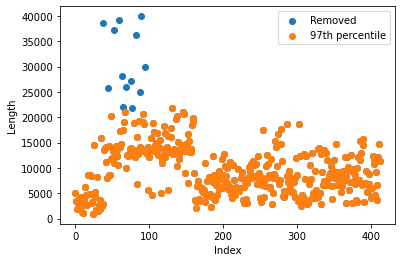

In [4]:
audio_size,audio_list_short,labels_short = length_finder(audio_path,df,97)
zebra_labels = pd.Series(data=labels_short, index=[np.arange(len(labels_short))])

In [5]:
audio_files = pad(audio_list_short,audio_size)

100%|███████████████████████████████████████| 400/400 [00:00<00:00, 4576.55it/s]


# Generate not zebera

In [6]:
nzebra_path = 'big bounce small.wav'
nzebra_audio, labels_nzebra = gen_nzebra(nzebra_path,audio_size)
#save_nzebra(nzebra_audio)

Padding


100%|███████████████████████████████████████| 422/422 [00:00<00:00, 5006.84it/s]


422


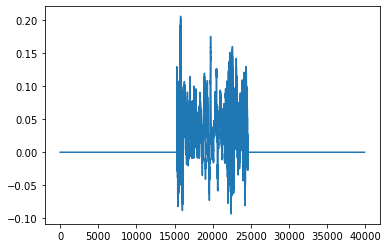

In [7]:
print(len(nzebra_audio))
plt.plot(nzebra_audio[2])

In [8]:
all_audio, all_lables = add_nzebra(audio_files,zebra_labels,nzebra_audio,labels_nzebra)

In [9]:
balanced, balanced_labels = balancer(all_audio,all_lables)

Initial class proportions:
[0.513 0.288 0.017 0.046 0.135]
----------------------
Balancing: not_zebra
Multiplier: 1.0
----------------------
Balancing: snort
Multiplier: 1.0
----------------------
Balancing: softsnort
Multiplier: 17.0
----------------------
Balancing: squeal
Multiplier: 5.0
----------------------
Balancing: whinnie
Multiplier: 0.0
----------------------
Final class proportions:
[0.352 0.198 0.199 0.159 0.093]


In [9]:
#print("Unaugmented dataset size: ",all_audio.nbytes/(1e9), 'GB')

# Augment Audio

In [10]:
augmented_audio = augment_audio_faster_smaller(audio_files)

Augmenting 400 samples


100%|████████████████████████████████████████| 400/400 [00:02<00:00, 183.72it/s]


In [11]:
print(augmented_audio.shape)
print("Augmented dataset size: ",augmented_audio.nbytes/(1e9), 'GB')

(4, 400, 119769)
Augmented dataset size:  1.5330432 GB


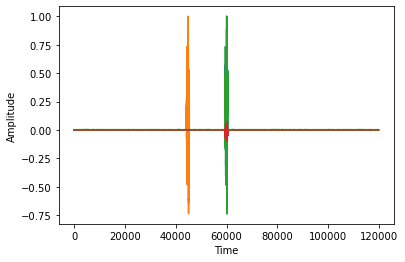

In [72]:
plot_sample(augmented_audio,10)

In [13]:
#stfts = calc_stft(augmented_audio)
mels = calc_melstft(augmented_audio)

100%|█████████████████████████████████████████████| 4/4 [00:14<00:00,  3.59s/it]


In [14]:
#stfts_norm_db = librosa.util.normalize(librosa.amplitude_to_db(stfts))
mels_norm_db = librosa.util.normalize(librosa.power_to_db(mels))

In [15]:
#print(stfts_norm_db.shape)
print(mels_norm_db.shape)
print("Augmented dataset size: ",mels_norm_db.nbytes/(1e9), 'GB')

(4, 400, 128, 234)
Augmented dataset size:  0.3833856 GB


spec_plot(stfts_norm_db[0,100,:,:])
plt.scatter(np.arange(0,len(stfts_norm_db[0,100,125,:])),stfts_norm_db[0,100,125,:],marker='x')
plt.xlabel("Time")
plt.show()
plt.scatter(np.arange(0,len(stfts_norm_db[0,100,:,125])),stfts_norm_db[0,100,:,125],marker='x')
plt.xlabel("Hz")
plt.show()

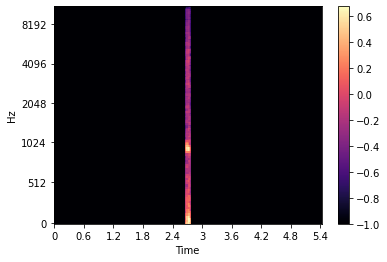

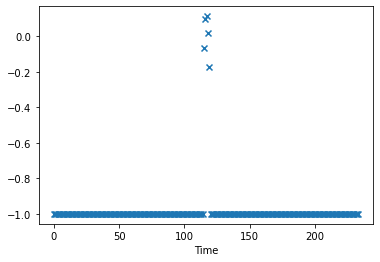

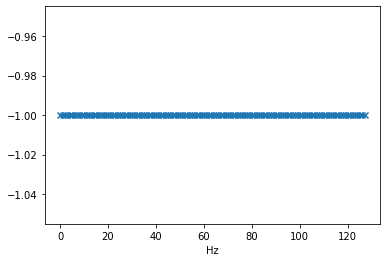

In [78]:
sampleidx = 10
librosa.display.specshow(mels_norm_db[0,sampleidx,:,:],x_axis="time",y_axis="mel")
#plt.imshow(librosa.amplitude_to_db(mels_norm_db[0,100,:,:]),origin='lower',aspect='auto')
plt.colorbar()
plt.show()
plt.scatter(np.arange(0,len(mels_norm_db[0,sampleidx,10,:])),mels_norm_db[0,sampleidx,10,:],marker='x')
plt.xlabel("Time")
plt.show()
plt.scatter(np.arange(0,len(mels_norm_db[0,sampleidx,:,100])),mels_norm_db[0,sampleidx,:,100],marker='x')
plt.xlabel("Hz")
plt.show()

stfts_1D = np.zeros(stfts[0].shape)
stfts_1D = stfts[0]
for i in tqdm(range(1,stfts.shape[0])):
    stfts_1D = np.concatenate((stfts_1D,stfts[i]), axis = 0)
stfts = None

In [17]:
mels_1D = np.zeros(mels_norm_db[0].shape)
mels_1D = mels_norm_db[0]
for i in tqdm(range(1,mels_norm_db.shape[0])):
    mels_1D = np.concatenate((mels_1D,mels_norm_db[i]), axis = 0)
mels = None

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.13it/s]


In [22]:
print(mels_1D.shape)
print("Dataset size: ",mels_1D.nbytes/(1e9), 'GB')

(1600, 128, 234)
Dataset size:  0.3833856 GB


In [77]:
np.savez_compressed('mels',mels_1D)
#stfts = np.load('stfts_array.npz')

In [20]:
#spec_plot(stfts_1D[0])

In [21]:
#listen(librosa.istft(stfts_1D[1220]))